# Unit Commitment by Reinforcement Learning

A toy game in which a Reinforcement Learning (RL) agent tries to operate a (very very simple) power grid. The rules of the game are simple: At every stage, the agent is presented with the current on/off status of generators and the forecast demand for the next time period. Generators may be offline (represented by 0), online (represented by 2) or ready (represented by 1). Whenever an online generator is turned off, it is unavailable for one turn and is available to be turned on the following turn. Each generator has a fixed output. The agent's goal is to turn on generators to most closely match the forecast demand. 

Our agent is going to attempt to learn this model by Q-Learning, a popular RL technique. Much of this code has been adapted from the [excellent tutorial from Hvass Laboratories](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/5e5266b13d7b1bdfdef19a4bf8d8a0458817bdf4/16_Reinforcement_Learning.ipynb) on RL for Atari gameplay.

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

## Game Parameters

In [2]:
#Initial settings for the game. 

num_gen = 5 #number of generators in the power system.
num_actions = 2**num_gen #the full set of actions available to the agent; on or off for each generator.
mean_demand = 25 #the mean demand for each time period.
standard_deviation = 4 #the standard deviation for the normally distributed demand.

#Generator settings.

all_gens = np.array([1,3,6,10,15,20,22,40]) #the outputs for 8 generators which may be used in the game.
gens = all_gens[:num_gen] #chooses the first num_gen of the generators for use in the game. 

#Define bounds on epsilon 

min_epsilon = 0.3
max_epsilon = 0.85

#Replay memory size - COME BACK TO THIS

rm_size = 100 

## Game Dynamics

The functions below define that game dynamics and are used for playing the game. The `Action` function takes an action and outputs a generation. `UpdateState` takes a state and action and outputs the new state. `Demand` generates a demand forecast from a normal distribution given by `mean_demand` and `standard_deviation` which are defined above. `Reward` calculates the absolute difference between the generation and demand. This is the agent's feedback as to the quality of its action.

In [3]:
def Action(action):
    action = np.array(action)
    generation = np.dot(gens, action)
    return generation

def UpdateState(state_original, action):
    state_original = np.array(state_original)
    action = np.array(action)
    state_new = np.copy(state_original)
    state_new[np.where(action == 0)] = 0
    state_new[np.where(state_original == 0)] = 1
    state_new[np.where(action == 1)] = 2
    state_new[np.where(action == 1)]
    state_new[np.argwhere((state_original == 1) & (action == 0)).flatten()] = 1

    return np.array(state_new)

def Demand(mean_demand): 
    demand = int(np.random.normal(mean_demand, standard_deviation))
    return demand

def Reward(demand, generation):
    reward = -abs(demand - generation)
    return reward

## Available Actions

The AvailableActions function returns the actions available to the agent based on the current status of generators. Remember, if a generator has been turned off last turn, it is not available to be committed until the next turn. 

In [4]:
allcomb = np.asarray(list(itertools.product([0, 1], repeat=num_gen)))

def AvailableActions(status):
    all_available = np.copy(allcomb)
    i = 0
    for gen in status:
        if gen == 0:
            all_available = all_available[(all_available[:,i] == 0)]
        i += 1            
    return(all_available)

## Q-Learning

In RL, we are ultimately looking for the optimal policy $\pi^{*}$ mapping states to actions. One way to do this is to find the optimal action-value function $Q^{*}$. An action-value function gives the expected return from taking action $a$ in state $s$ and following $\pi$ thereafter:

$$Q^\pi(s,a) = E_\pi\{R_t|s_t = s, a_t = a\}$$

If we find $Q^{*}$, the optimal poicy simply chooses the action with the highest Q-value at each time step.

## Epsilon-Greedy Policy 

Without pre-encoding the transition dynamics (i.e. $\Pr(s_{t+1} = s' | s_t = s, a_t = a)$), the agent must learn Q-values by trial and error. The agent begins by playing the game with an arbitrary, epislon-greedy policy to gain experience and begin estimating Q-values. The epsilon-greedy element of the agent's policy ensures that it explores different actions: it is forced to take a random action with probability $1-\epsilon$.


In [5]:
def EpsilonGreedy(all_available, q_values, epsilon): 
    if np.random.random() < epsilon:
        idx = np.random.randint(len(all_available))
        action = all_available[idx]
    else: 
        idx = np.argmax(q_values)
        action = all_available(idx)
    return action    

## Replay Memory

As the agent plays, it builds a Replay Memory. The Replay Memory stores the agent's experience in the form of $\langle$state, action, reward, Q-value$\rangle$ tuples. The Replay Memory is of a fixed size. Once it is full, we perform a backsweep and make the following update to the Q-values: 

$$Q(S_t, A_t)\gets Q(S_t, A_t)+\alpha\left[R_{t+1}+\gamma\max_a Q(S_{t+1}, a) - Q(S_t, A_t) \right]$$

Here we are slowly (learning rate determined by $\alpha$) updating our Q-values towards the Q-values we got from experience given by $R_{t+1}+\gamma\max_a Q(S_{t+1}, a)$ (called the TD-target). Crucially, the TD-target is calculated by bootstrapping: we measure the reward received from taking an action and add to our estimate for the Q-value of the state we arrived at. As we perform a backsweep, we use this bootstrapping to update the Q-values from the end of the Replay Memory (the last tuple we recorded) right the way back to the beginning. 

In addition, we multiply the bootstrapped Q-value estimate for state $S_{t+1}$ by a discount factor $\gamma$. The discount factor is a way of addressing the so-called Credit Assignment Problem. That is we want to maintain a balance between attributing rewards to actions that came immediately before it, whilst recognising that earlier actions may have had an impact too. 



In [6]:
class ReplayMemory: 
    
    def __init__(self, size, num_actions, discount_factor = 0.8):
        
        self.size = size
        self.states = np.zeros(shape = [size] + [num_gen + 1], dtype = np.uint8)
        self.q_values = np.zeros(shape = [size, num_actions], dtype = np.float)
        self.q_values_old = np.zeros(shape = [size, num_actions], dtype = np.float)
        self.actions = np.zeros(shape = size, dtype = np.int)
        self.rewards = np.zeros(shape = size, dtype = np.int)
        self.estimation_errors = np.zeros(shape = size, dtype = np.int)
        self.discount_factor = discount_factor
        self.num_used = 0
        self.error_threshold = 0.1
        
    def is_full(self):
        
        return self.num_used == self.size
    
    def reset(self):
        
        self.num_used = 0
        
    def add(self, state, q_values, action, reward):
        
        if not self.is_full():
            
            k = self.num_used
            
            self.num_used += 1

            self.states[k] = state
            self.q_values[k] = q_values
            self.actions[k] = action
            self.rewards[k] = reward
            
    def update_all_q_values(self):
        
        self.q_values_old[:] = self.q_values[:]
        for k in reversed(range(self.num_used - 1)):
            action = self.actions[k]
            reward = self.rewards[k]
            action_value = reward + self.discount_factor * np.max(self.q_values[k+1])
        
            self.estimation_errors[k] = abs(action_value - self.q_values[k,action])
            
            self.q_values[k,action] = action_value
            
    def random_batch(self, batch_size):
        
        idx = np.random.choice(self.size, batch_size, replace = False)
        states_batch = self.states[idx]
        q_values_batch = self.q_values[idx]
        
        return states_batch, q_values_batch
            

## Neural Network

With the experience stored in the Replay Memory and the updated Q-values, we have everything we need to approximate the Q-value function using a neural network. The neural network fits a function that maps states to Q-values for all actions. 

in training, we take a random batch of states (input) and Q-values (output) and perform stochastic gradient descent to update the neural network weights. Our loss function is just the sum of squared errors between Q-value estimates produced by our current neural network and the 'actual' (remember these are still estimates, just better ones) Q-values from the Replay Memory. 

In [7]:
class NeuralNetwork:
    
    def __init__(self, num_actions, replay_memory):
        
        self.replay_memory = replay_memory
        
        self.x = tf.placeholder(dtype = tf.float32, shape = (None, num_gen + 1))
        
        self.learning_rate = tf.placeholder(dtype = tf.float32, shape = [])
        
        self.q_values_new = tf.placeholder(tf.float32, 
                                           shape = [None, num_actions],
                                           name = 'q_values_new')
        
        init = tf.truncated_normal_initializer(mean=0.0, stddev=2e-2)
        activation = tf.nn.relu
        num_output = num_actions
        
        net = self.x
        
        net1 = tf.layers.dense(inputs=net, name='layer_fc1', units=6,
                                          kernel_initializer=init, activation=activation, 
                                          reuse = tf.AUTO_REUSE)
        
        net2 = tf.layers.dense(inputs=net1, name='layer_fc_out', units=num_output,
                                          kernel_initializer=init, activation=None, 
                                          reuse = tf.AUTO_REUSE)
        

        self.q_values = net2
        
        squared_error = tf.square(self.q_values - self.q_values_new)
        sum_squared_error = tf.reduce_sum(squared_error, axis=1)
        self.loss = tf.reduce_mean(sum_squared_error)

        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss)    
        
        self.session = tf.Session()
        
        self.session.run(tf.global_variables_initializer())
        
    def get_q_values(self, states):
        
        feed_dict = {self.x: states}
        values = self.session.run(self.q_values, feed_dict = feed_dict)
        
        return values
    
    
    
    def optimize(self, min_epochs = 1.0, max_epochs = 10, batch_size = 10,
                 loss_limit = 0.01, learning_rate = 0.01):
        
        loss_history = np.zeros(100, dtype=float)
        
        iterations_per_epoch = self.replay_memory.num_used / batch_size
        min_iterations = int(iterations_per_epoch * min_epochs)
        max_iterations = int(iterations_per_epoch * max_epochs)
        
        for i in range(max_iterations):
            
            state_batch, q_values_batch = self.replay_memory.random_batch(batch_size)
            
            feed_dict = {self.x: state_batch,
                         self.q_values_new: q_values_batch,
                         self.learning_rate: learning_rate}
            
            loss_val, _ = self.session.run([self.loss, self.optimizer], 
                                           feed_dict = feed_dict)
            
            loss_history = np.roll(loss_history, 1)
            loss_history[0] = loss_val
            
            loss_mean = np.mean(loss_history)
            
            if i > min_iterations and loss_mean < loss_limit:
                break

## Simulation 

Now we are ready to simulate and begin training the RL agent. At each iteration, the agent will act following an epsilon-greedy policy based on Q-values estimated by the neural network. Every $\langle$state, action, reward, Q-value$\rangle$ is recorded in the Replay Memory which, when full, is sampled from to train the neural network using stochastic gradient descent. 

The second part of the `simulate` function measures the agents performance by playing with a greedier policy and recording the average reward. We also record the rewards of a benchmark random policy for comparison.

In [8]:
def Simulate(num_iterations):
    
    gen_status = np.random.randint(3, size = num_gen)

    demand = Demand(mean_demand)
    
    state = np.append(gen_status, demand).reshape(1, num_gen + 1)
        
    for j in range(num_iterations):
        
    #Defining the control signal for epsilon. Epsilon increments by 1/num_iterations
    #at each iteration. Starts at min_epsilon, goes to max_epsilon
        
    #   epsilon = min_epsilon + j*((max_epsilon - min_epsilon)/num_iterations)
        epsilon = 0.8
              
        for i in range(rm_size):
            
            qs = nn.get_q_values(state)
            
            available_actions = AvailableActions(state[0][:num_gen])
            
            available_actions_idx = list()
            
            for act in available_actions:
                available_actions_idx.append(int(np.where(np.all(allcomb == act, axis = 1))[0]))
            
            if np.random.rand() < epsilon:
                
                action = np.amax(qs[0][available_actions_idx])
                action = int(np.where(qs[0] == action)[0])
                generation = Action(allcomb[action])    
                
            else:
                
                action = np.random.choice(available_actions_idx)
                generation = Action(allcomb[action]) 
            
            reward = Reward(demand, generation)
            rm.add(state, qs, action, reward)
        
            state = UpdateState(state[0][0:num_gen], allcomb[action])
            demand = Demand(mean_demand)
            state = np.append(state, demand).reshape(1,num_gen + 1)
            
        rm.update_all_q_values()
        
        nn.optimize()
        
        rm.reset()
    
        totalreward = 0
        total_random_reward = 0
        
        #Measuring the performance of the RL agent.
        
        if j % 5 == 0:
        
            for k in range(200):
    
                
                qs = nn.get_q_values(state)
                available_actions = AvailableActions(state[0][:num_gen])
                available_actions_idx = list()
                
                for act in available_actions:
                    available_actions_idx.append(int(np.where(np.all(allcomb == act, axis = 1))[0]))
                    
                if np.random.rand() < 0.99:
                    
                    action = np.amax(qs[0][available_actions_idx])
                    action = int(np.where(qs[0] == action)[0])
                    generation = Action(allcomb[action])
                    
        
                else:
                    
                    action = np.random.choice(available_actions_idx)
                    generation = Action(allcomb[action])
                
                reward = Reward(demand, generation)  
                totalreward = totalreward + reward
                
                state = UpdateState(state[0][0:num_gen], allcomb[action])
                demand = Demand(mean_demand)
                state = np.append(state, demand).reshape(1,num_gen + 1)
            
                #Try a random action for reference:
                
                random_generation = Action(allcomb[np.random.choice(available_actions_idx)])
                random_reward = Reward(demand, random_generation)
                total_random_reward = total_random_reward + random_reward
            
            rewards_data.append(float(totalreward)/200)
            random_rewards_data.append(float(total_random_reward)/200)
        
    plt.plot(rewards_data)
    plt.plot(random_rewards_data)
    plt.legend(["rewards", "random rewards"], loc = "upper left")
    plt.savefig('plt.png')
    plt.show()

Now let's intialise the Replay Memory and neural network. 

In [9]:
rm = ReplayMemory(rm_size, num_actions)  
nn = NeuralNetwork(num_actions, rm)

We also make empty lists for recording the rewards during testing, as well as the random rewards. 

In [10]:
rewards_data = list()
random_rewards_data = list()

Let's run some simulations. 100 iterations to begin with. Remember, a single iteration fills up the Replay Memory, then trains the neural network from it. We have set the size of the Replay Memory with `rm_size`, so the total number of turns taken by the agent is `rm_size` * `num_iterations`. We can repeat this as many times as we like to improve our RL agent, and observe the improvements on the graph.

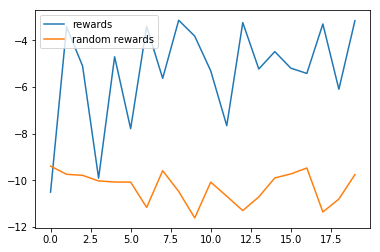

In [11]:
Simulate(100)